# **Time Series Forecasting of Netflix Stock Prices**

# Nextflix Stock Market Prediction using Time Series Forecasting (XGBOOST)

The project's goal is to leverage time series analysis to predict stock market price of Netflix. 

# Data
Many academics and analysts have found it challenging to master the art of predicting stock values. Indeed, investors are keenly engaged in the field of stock price prediction research. Many investors want to know the stock market's future scenario in order to make a smart and profitable investment. Good and successful stock market prediction systems assist traders, investors, and analysts by giving useful information such as the stock market's future direction.

The dataset is taken from Kaggel - Netflix Stock Price Prediction.The Dataset contains data for 5 years(5th Feb 2018 to 5th Feb 2022).
Some of the features in the data are:

1. Date - Everyday price
2. Open - Price at which stock opens
3. High - Today's High
4. Low - Today's low
5. Close - Close price adjusted for splits
6. Adj Close - Adjusted close price adjusted for splits and dividend and/or capital gain distributions.
7. Volume - Volume of stocks. 


# Importing Dataset
The very first step of virtually every data science project is importing the dataset we’ll be working with along with the libraries needed for the first sections.

The libraries needed for the data import and EDA portions of the project are certainly Pandas and NumPy, along with Matplotlib and Seaborn.

In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
uploaded = files.upload()

Saving NFLX.csv to NFLX.csv


In [215]:
df = pd.read_csv('NFLX.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


In [216]:
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


Checking if the dataset contains any null values

In [217]:
nan_count = df.isna().sum().sum()
nan_count

0

## **Exploratory Data Analysis**

We can now focus on data exploration and visualization.

I started by plotting a correlation matrix using seaborn. The correlation matrix shows us the single correlation between each feature and the others on the dataset. In general, the correlation can be:

< 0.3 and therefore weak
between 0.3 and 0.6 and therefore moderate
between 0.6 and 0.9 and therefore strong
/ > 0.9 extremely strong

The sign, on the other hand, indicates whether the two factors grow in the same direction or in the opposite one. A correlation of -0.9 indicates that as one variable increases the other decreases. Depending on the uncertainty of the environment though, the ranges can change. In quantitative finance, a 0.3 or 0.4 correlation can be considered strong.

Observations from the heatmap:

Open, High, Close, Adj Close, Low, are strongly correlated to all each others. 

Volume shows a weak correlation with others. 

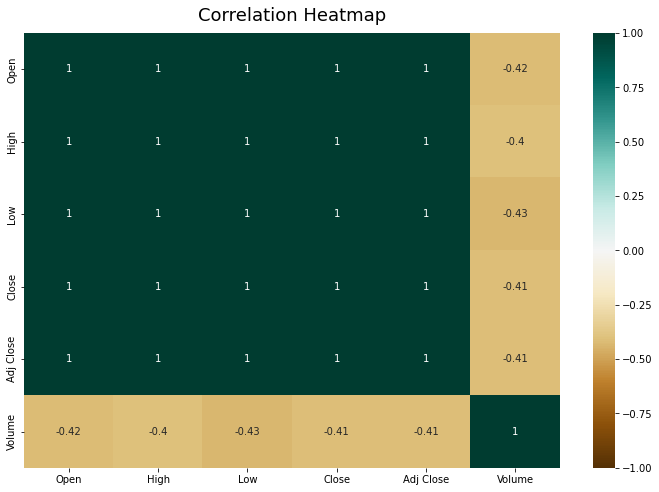

In [218]:
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

**Feature Creation**


In time series analysis and forecasting, “time” can be the only feature you have at your disposal so it’s better to extract as much information as possible from it. The following function creates columns out of the DateTime index. For example, at the time 1/1/2017 0:10 , the command df.index.hour will extract the value 0, since it’s midnight. df.index.dayofweek will show a 6 as January 1st, 2017 was a Sunday (numeration starts from 0), and so on.
By running the function create_features on our df, we instantly create all the features defined in the function.

In [219]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df
df = create_features(df)

In [220]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,,,,,,,
2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100,0,0,1,2,2018,36,5,6
2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800,0,1,1,2,2018,37,6,6
2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500,0,2,1,2,2018,38,7,6
2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700,0,3,1,2,2018,39,8,6
2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900,0,4,1,2,2018,40,9,6


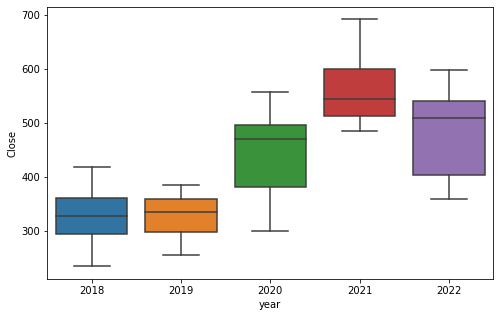

In [189]:
import seaborn as sns

fig, ax = plt.subplots(1, figsize=(8,5))
sns.boxplot(x='year', y='Close', data=df, ax=ax, showfliers=False)
plt.show()

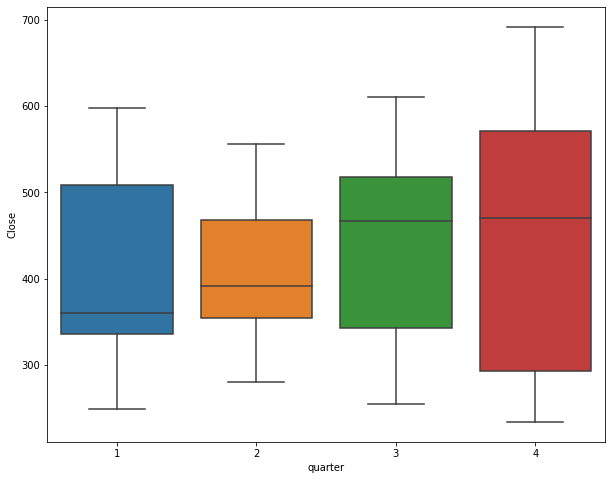

In [190]:
import seaborn as sns

fig, ax = plt.subplots(1, figsize=(10,8))
sns.boxplot(x='quarter', y='Close', data=df, ax=ax, showfliers=False)
plt.show()

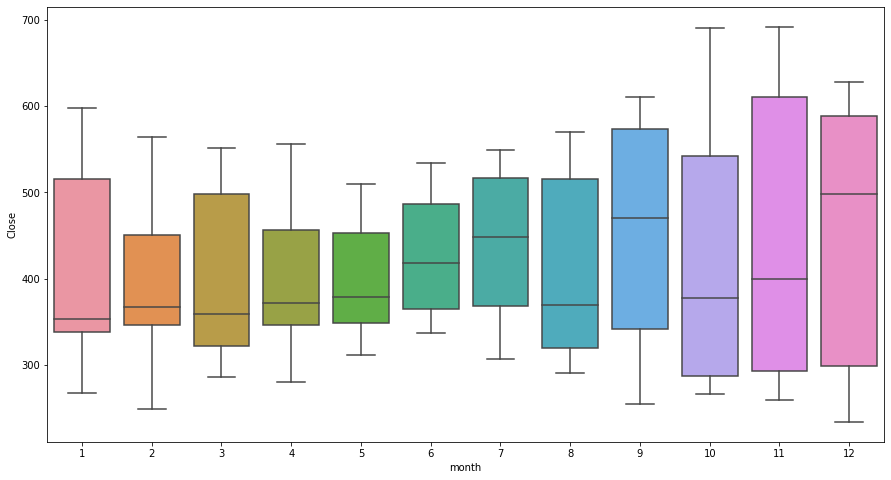

In [191]:
import seaborn as sns

fig, ax = plt.subplots(1, figsize=(15,8))
sns.boxplot(x='month', y='Close', data=df, ax=ax, showfliers=False)
plt.show()

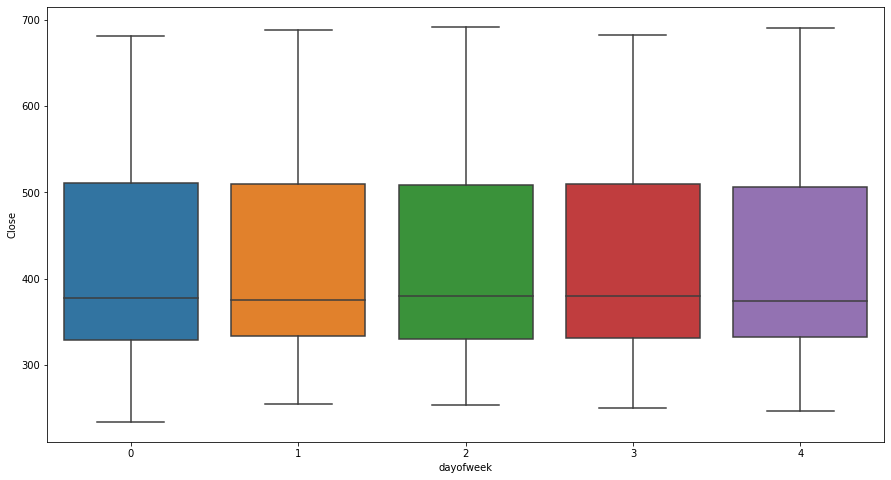

In [192]:
import seaborn as sns

fig, ax = plt.subplots(1, figsize=(15,8))
sns.boxplot(x='dayofweek', y='Close', data=df, ax=ax, showfliers=False)
plt.show()

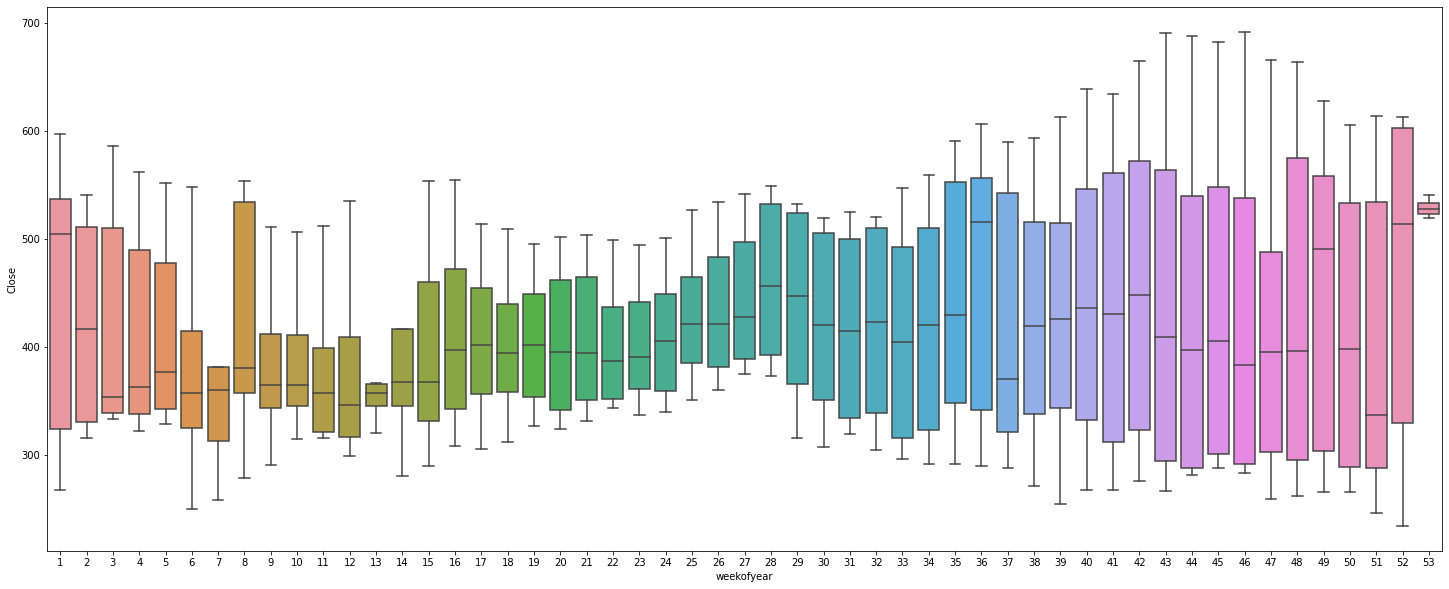

In [193]:
import seaborn as sns

fig, ax = plt.subplots(1, figsize=(25,10))
sns.boxplot(x='weekofyear', y='Close', data=df, ax=ax, showfliers=False)
plt.show()

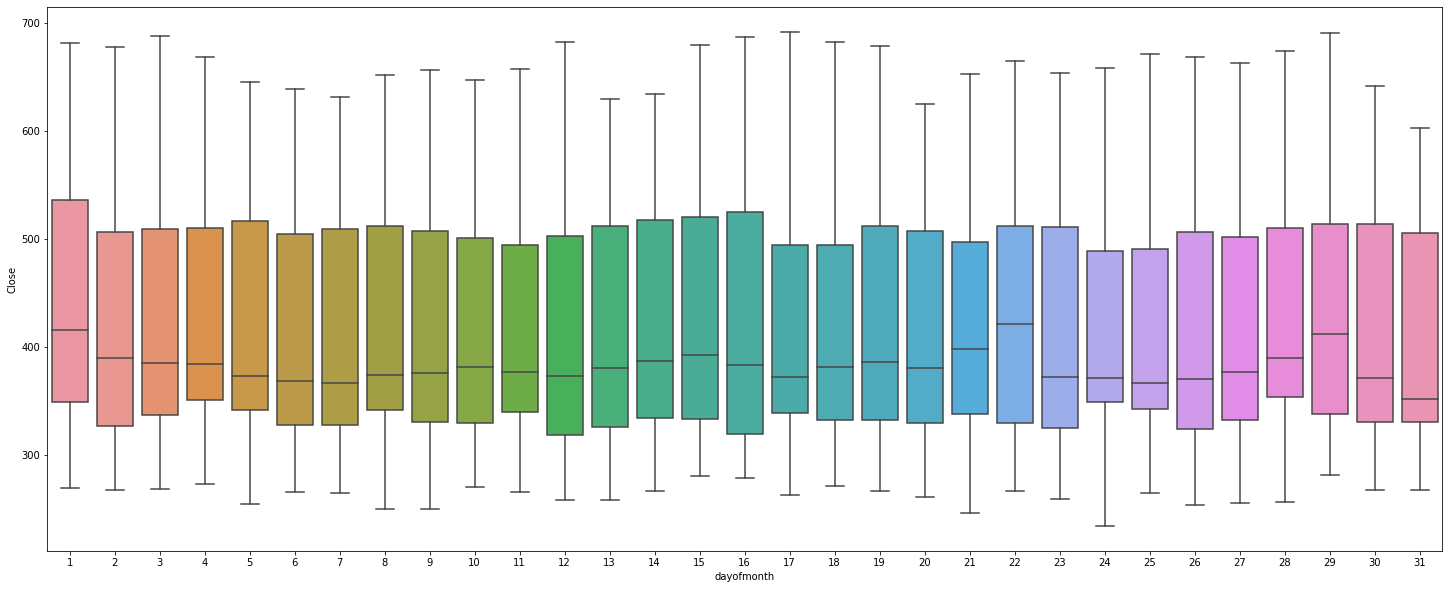

In [194]:
import seaborn as sns

fig, ax = plt.subplots(1, figsize=(25,10))
sns.boxplot(x='dayofmonth', y='Close', data=df, ax=ax, showfliers=False)
plt.show()

In [195]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.arima.model import ARIMA

In [196]:
def ADF_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [197]:
ADF_test(df['Close'])

Results of Dickey-Fuller Test:
Test Statistic                   -1.812591
p-value                           0.374229
Lags Used                         6.000000
Number of Observations Used    1002.000000
Critical Value (1%)              -3.436893
Critical Value (5%)              -2.864429
Critical Value (10%)             -2.568308
dtype: float64


# **Train Test Split**

At this stage, the dataset can be split between training and testing. In a normal scenario, we would randomly select new records to train the algorithm and test it on the remaining ones. In this case, it’s important to preserve a time sequence between the training and testing records. Therefore 70 percent of data from 2018-02-01 to 2021-06-01 is in the traning dataset and the data from 2021-06-01 to 2022-02-01 is in the testing set. 

In [221]:
X_train = df.loc[:'2021-06-01 00:00:00',['Open','High', 'Low', 'Volume', 'month', 'quarter', 'dayofweek', 'year']]
y_train = df.loc[:'2021-06-01 00:00:00', ['Close']]
X_test = df.loc['2021-06-01 00:00:00':,['Open','High', 'Low', 'Volume', 'month', 'quarter' ,'dayofweek', 'year']]
y_test = df.loc['2021-06-01 00:00:00':, ['Close']]

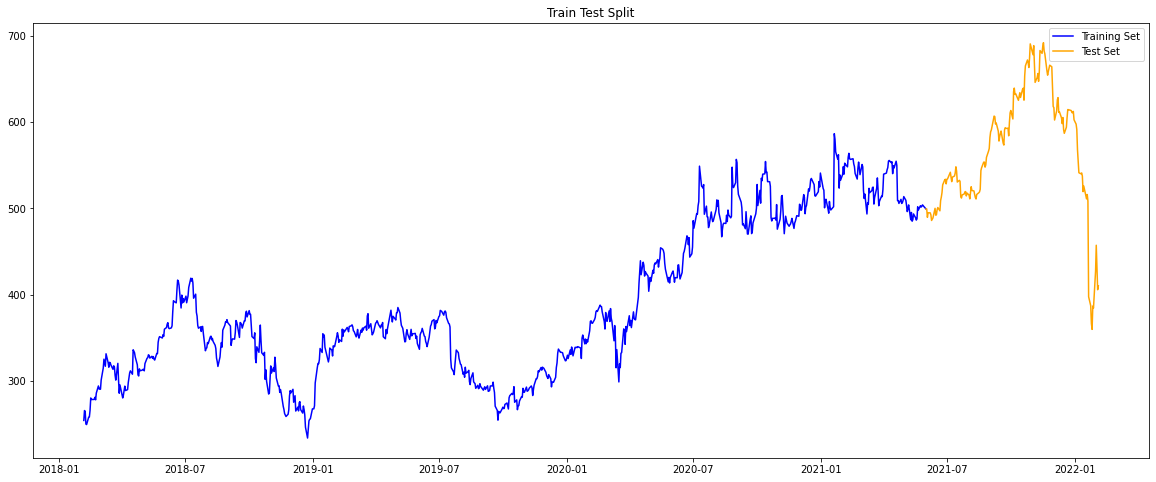

In [222]:
plt.figure(figsize=(20, 8))
plt.plot(X_train.index, y_train, label='Training Set',color='blue')
plt.plot(X_test.index, y_test, label='Test Set', color = 'orange')
plt.legend()
plt.title('Train Test Split')
plt.show()

# **Predictions**

To predict records in our test set I have used Gradient Bossting (XGBOOST) algorithm. 

Hyperparameters settings for the algorithm is as follows:


n_estimators : the number of learning rounds the XGBoost algorithm will try to learn from the training data

max_depth : the maximum depth a tree can have, a deeper tree is more likely to cause overfitting

learning_rate : or shrinkage factor, as new trees are created to correct residual errors, the learning rate (<1.0) “slows down” the ability of the model to fit the data and consequently learn as the number of trees increases

verbose : how often the model prints out on the console the result, we set 100 here as the n_estimators is quite high. The default value is 1

In [223]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=2000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=12,
                       learning_rate=0.003, 
                       random_state = 68)
reg.fit(X_train, y_train,         
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[22:25:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:396.287	validation_1-rmse:569.42
[100]	validation_0-rmse:294.185	validation_1-rmse:439.772
[200]	validation_0-rmse:218.447	validation_1-rmse:342.009
[300]	validation_0-rmse:162.243	validation_1-rmse:268.407
[400]	validation_0-rmse:120.525	validation_1-rmse:213.342
[500]	validation_0-rmse:89.5645	validation_1-rmse:172.326
[600]	validation_0-rmse:66.5918	validation_1-rmse:141.829
[700]	validation_0-rmse:49.5529	validation_1-rmse:119.302
[800]	validation_0-rmse:36.9254	validation_1-rmse:102.691
[900]	validation_0-rmse:27.5788	validation_1-rmse:90.0381
[1000]	validation_0-rmse:20.6756	validation_1-rmse:80.4575
[1100]	validation_0-rmse:15.5965	validation_1-rmse:72.868
[1200]	validation_0-rmse:11.8784	validation_1-rmse:66.8389
[1300]	validation_0-rmse:9.16266	validation_1-rmse:61.9555
[1400]	validation_0-rmse:7.14256	validation_1-rmse:57.6298
[1

XGBRegressor(early_stopping_rounds=50, learning_rate=0.003, max_depth=12,
             n_estimators=2000, random_state=68)

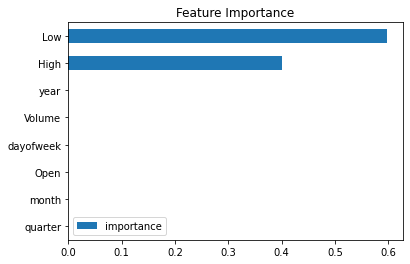

In [224]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=X_train.columns,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

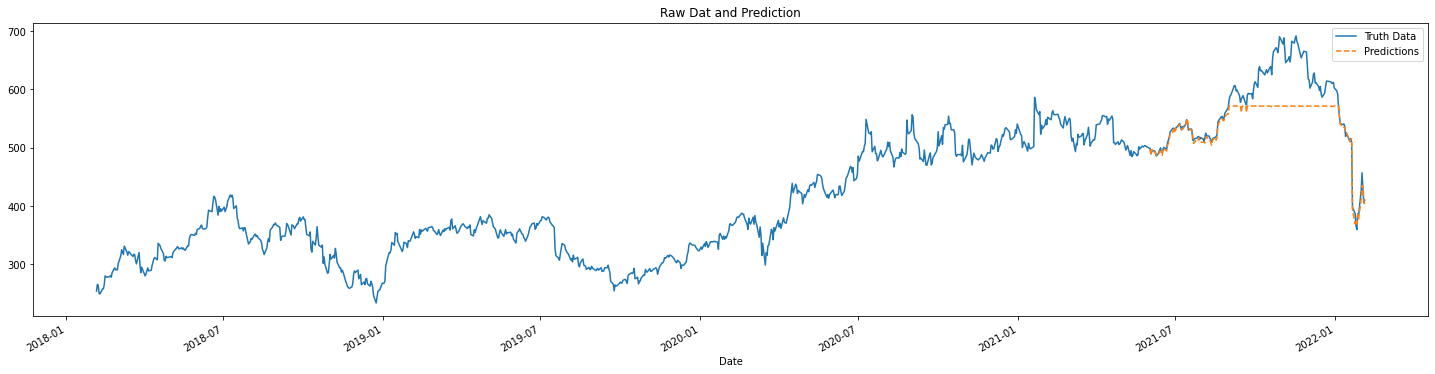

In [225]:
y_test['prediction'] = reg.predict(X_test)
df = df.merge(y_test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['Close']].plot(figsize=(25, 6))
df['prediction'].plot(ax=ax, style='--')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()